# Supervised Machine Learning: Regression

## Table of contents

### [1. Libraries and Data importations](#1)
### [2. Data Preparation](#2)

-[ Data cleaning](#2.1)

-[ Data subsetting](#2.2)

-[ Data standardization](#2.3)

### [3. Principal Components Analysis (PCA)](#3)

-[ Defining the number of components (causes of deaths)](#3.1)

-[ PCA applied and added to the subset](#3.2)

### [4. K-means clustering analysis](#4)

-[ Defining the number of clusters (elbow method)](#4.1)

-[ Implementing K-means](#4.2)

-[ Dataframe concatenation](#4.3)

-[ Results analysis](#4.4)

### [5. Conclusions](#5)

## 1. Libraries and Data importations
<div id='1'></div>

In [4]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sklearn
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pylab as pl


##to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Creating paths to the data folder of the project and to the folder for saving the charts
path_data = r'C:\Users\dacol\Documents\Data Project - careerfoundry\Europe health-deaths analysis\02 Data'
path_viz = r'C:\Users\dacol\Documents\Data Project - careerfoundry\Europe health-deaths analysis\04 Analysis\Visualizations'

# Importing the latest merged dataframe
df = pd.read_pickle(os.path.join(path_data,'Prepared Data','cod_merged_full.pkl'))


## 2. Data Preparation
<div id='2'></div>

### Data cleaning
<div id='2.1'></div>

In [7]:
df.shape

(45692, 114)

In [8]:
df.isnull().sum()

geo_code                                                       0
country_region                                                 0
year                                                           0
sex                                                            0
age                                                            0
                                                           ...  
Too expensive                                              44203
Too expensive or too far to travel or waiting list         44203
Too far to travel                                          44203
Waiting list                                               44203
Wanted to wait and see if problem got better on its own    44203
Length: 114, dtype: int64

All nulll values are either form mismatched scopes from the different datasets, or from unavailble data from Eurostat. The most important column being the aggregate of all causes of deaths, cleaning this column from null values is necessary.

In [10]:
df.dropna(subset=['A-R_V-Y: All causes of death (A00-Y89) excluding S00-T98'])

,geo_code,country_region,year,sex,age,A-R_V-Y: All causes of death (A00-Y89) excluding S00-T98,A15-A19_B90: Tuberculosis,"ACC: Accidents (V01-X59, Y85, Y86)","ACC_OTH: Other accidents (W20-W64, W75-X39, X50-X59, Y86)",A_B: Certain infectious and parasitic diseases (A00-B99),...,Didn't know any good doctor or specialist,"Fear of doctor, hospital, examination or treatment",No time,No unmet needs to declare,Other reason,Too expensive,Too expensive or too far to travel or waiting list,Too far to travel,Waiting list,Wanted to wait and see if problem got better on its own
0,AT,Austria,2011,F,TOTAL,920.47,0.46,24.45,11.02,8.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AT,Austria,2011,F,Y_GE65,4051.37,1.96,101.39,51.15,34.18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AT,Austria,2011,F,Y_LT65,131.62,0.09,5.06,0.90,1.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AT,Austria,2011,M,TOTAL,880.37,0.83,35.93,12.84,7.88,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AT,Austria,2011,M,Y_GE65,4402.11,4.03,125.77,53.46,32.37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48577,UKN0,Northern Ireland (UK) (NUTS 2021),2018,M,Y_GE65,4308.63,3.61,113.50,26.03,53.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48578,UKN0,Northern Ireland (UK) (NUTS 2021),2018,M,Y_LT65,213.73,0.00,21.03,2.93,1.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48579,UKN0,Northern Ireland (UK) (NUTS 2021),2018,T,TOTAL,834.56,0.32,30.65,5.06,9.81,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48580,UKN0,Northern Ireland (UK) (NUTS 2021),2018,T,Y_GE65,4202.75,1.96,116.62,20.91,50.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
dups = df.duplicated()
dups.shape # no duplicates found

(45692,)

### Data subsetting
<div id='2.2'></div>

In [13]:
#limiting dataframe to the rows containing the total deaths from age groups and genders

df_sub_age = df[df['age'] == 'TOTAL'] 
df_sub_age_sex = df_sub_age[df_sub_age['sex'] == 'T']
df_sub_age_sex.shape

(5212, 114)

In [14]:
#droping all columns that are not causses of deaths (without its aggregated column)

df_final_sub = df_sub_age_sex.loc[:, "A15-A19_B90: Tuberculosis": "Y10-Y34_Y872: Event of undetermined intent"]

In [15]:
#Filling Nan values with zeros on the final subset since they are not supported by sklearn functions

df_final_sub.fillna(0, inplace =True)

In [16]:
print (df_final_sub.shape)
print (df_final_sub.info(all)) #the subset is ready for next steps

(5212, 91)
<class 'pandas.core.frame.DataFrame'>
Index: 5212 entries, 6 to 48579
Data columns (total 91 columns):
 #   Column                                                                                                        Non-Null Count  Dtype  
---  ------                                                                                                        --------------  -----  
 0   A15-A19_B90: Tuberculosis                                                                                     5212 non-null   float64
 1   ACC: Accidents (V01-X59, Y85, Y86)                                                                            5212 non-null   float64
 2   ACC_OTH: Other accidents (W20-W64, W75-X39, X50-X59, Y86)                                                     5212 non-null   float64
 3   A_B: Certain infectious and parasitic diseases (A00-B99)                                                      5212 non-null   float64
 4   A_B_OTH: Other infectious and parasitic disease

### Data standardization
<div id='2.3'></div>

In [18]:
scaler= StandardScaler() #creating the scaler object with the function
df_final_sub = scaler.fit_transform(df_final_sub) #applying standardization on the deaths counts by causes

## 3. Principal Components Analysis (PCA)
<div id='3'></div>

### Defining the number of components (causes of deaths)
<div id='3.1'></div>

- There are 91 referenced death causes, too many for such a clustering study, isolating the main components and reducing the noise for the k-means study is necessary.

- Since all variable share the same unit of number of deaths per 100K inhabitants, no standardization is needed for the PCA.

In [21]:
#Fitting PCA to the subset of death causes
pca = PCA()
pca.fit(df_final_sub)

PCA()

In [22]:
#showing how much variance is explained by each of the 91 individual components

pca.explained_variance_ratio_

array([2.71202534e-01, 1.32691259e-01, 6.24487625e-02, 5.26914188e-02,
       3.85879432e-02, 3.72751197e-02, 3.13216680e-02, 2.69152587e-02,
       2.34481077e-02, 2.05401781e-02, 1.80465474e-02, 1.62124917e-02,
       1.54578513e-02, 1.36497432e-02, 1.33531755e-02, 1.19396059e-02,
       1.05956087e-02, 1.03334156e-02, 9.67484023e-03, 9.32960472e-03,
       8.32721095e-03, 8.09726495e-03, 7.94777086e-03, 7.71465266e-03,
       7.30568358e-03, 6.60924824e-03, 6.11295577e-03, 5.77749455e-03,
       5.75233946e-03, 5.51190978e-03, 5.11335847e-03, 4.95068392e-03,
       4.81844718e-03, 4.68287440e-03, 4.43584476e-03, 4.24294055e-03,
       4.04193605e-03, 3.89346373e-03, 3.53349909e-03, 3.52292682e-03,
       3.39846366e-03, 3.26252419e-03, 3.04487421e-03, 2.98867416e-03,
       2.73741089e-03, 2.69009986e-03, 2.62039555e-03, 2.58148886e-03,
       2.43333148e-03, 2.28771237e-03, 2.20232121e-03, 2.13557336e-03,
       2.06448003e-03, 1.98023819e-03, 1.87162137e-03, 1.72151022e-03,
      

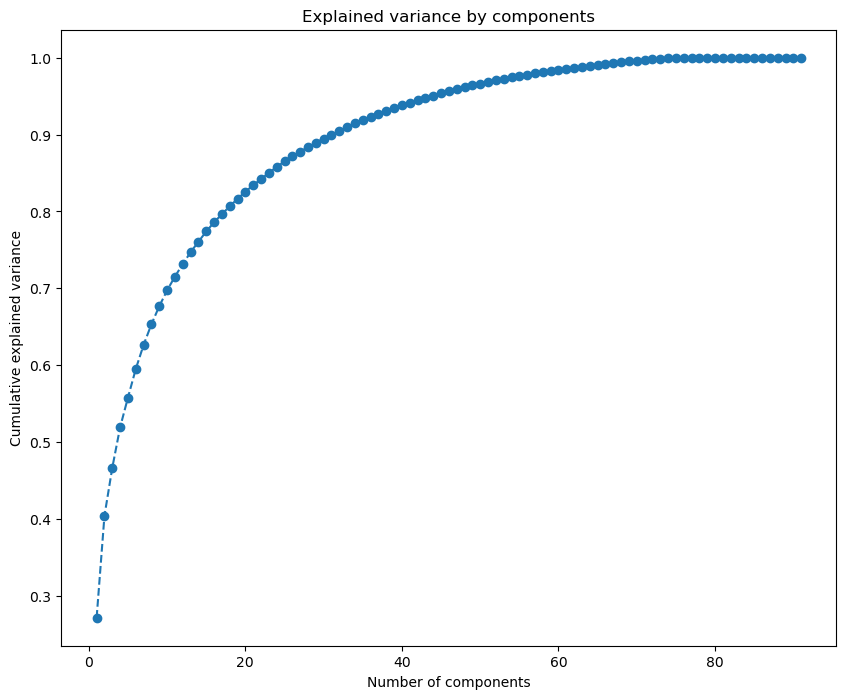

In [23]:
#ploting the variance results

plt.figure(figsize= (10,8))
plt.plot(range(1,92), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle ='--')
plt.title('Explained variance by components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

Keeping up to 10 components could account for about 70% of the variance, while 18 for 80%. A compromise could be 12 components, keepong the steepest ones.

### PCA performing
<div id='3.2'></div>

In [26]:
#applying the PCA limited to 7 components
pca = PCA(n_components = 12)

In [27]:
#fitting the model on the final subset
pca.fit(df_final_sub)

PCA(n_components=12)

In [28]:
#Calculated resulting components score for the causes of deaths
pca.transform(df_final_sub)

array([[-0.26309601,  0.99679018, -0.20097898, ...,  1.6843141 ,
        -0.24055568, -1.06094793],
       [ 0.21387222,  0.94594134, -0.0224021 , ...,  1.65592429,
        -0.35951907, -1.02482361],
       [-0.01562784,  0.78853327, -0.25039312, ...,  1.58240675,
        -0.35931108, -0.9237437 ],
       ...,
       [-0.33628082, -2.65778641, -3.12976818, ..., -0.23253005,
         0.70250652, -0.47035063],
       [ 0.34574744, -3.04652362, -3.5103718 , ...,  0.01155676,
        -0.37982782, -0.05418538],
       [ 0.05302776, -3.05487724, -3.80066989, ..., -0.7880023 ,
        -0.08985453, -0.29049318]])

In [29]:
#saving the score to new object on which the k-mean will be performed
scores_pca = pca.transform(df_final_sub)

## 4. K-means clustering analysis
<div id='4'></div>

### Defining the number of clusters (elbow method)
<div id='4.1'></div>

In [32]:
num_cl = range(1, 20) # Defines the range of potential clusters in the data
kmeans = [KMeans(n_clusters=i) for i in num_cl] # Defines k-means clusters in the range assigned above

In [33]:

#creating a score that represent the range of variation for the cluster option of 20
score = [kmeans[i].fit(scores_pca).score(scores_pca) for i in range(len(kmeans))]


score

  File "C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[-346888.2944762885,
 -258976.6437701511,
 -209439.87805773923,
 -187040.65979774392,
 -175063.36082425943,
 -167650.9660631317,
 -156519.12463944015,
 -139765.31055015302,
 -129955.84029420456,
 -119018.88375571571,
 -109132.70939405424,
 -100825.15669218036,
 -94667.78253492761,
 -90022.30222510338,
 -86211.73837104948,
 -82692.57476095662,
 -77563.2295004641,
 -75019.31235621031,
 -76071.64040999225]

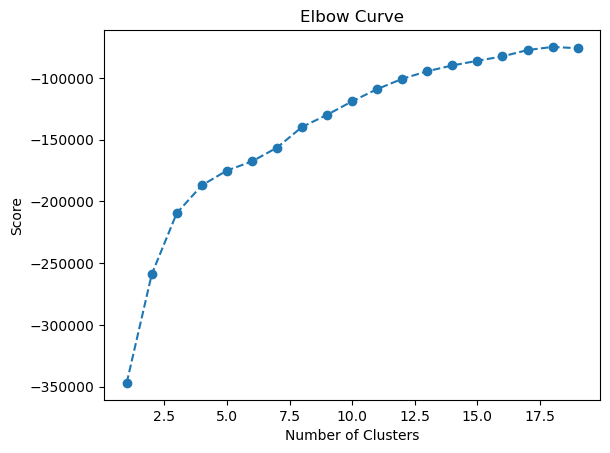

In [34]:
# Ploting the elbow curve

pl.plot(num_cl,score, marker='o', linestyle='--')
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

Keeping 4 clusters seems to be a good choice, with a flattened slope after the fourth cluster

### Implementing K-means
<div id='4.2'></div>

In [87]:
# Creating the k-means object

kmeans = KMeans(n_clusters = 4) 

In [88]:
# Fitting the k-means object to the data

kmeans.fit(scores_pca)

KMeans(n_clusters=4)

### Dataframe concatenation
<div id='4.3'></div>


In [90]:
#adding PCA score and the assignbed cluster on the initial subset
df_sub_pca_kmeans = pd.concat([df_sub_age_sex.reset_index(drop =True), pd.DataFrame(scores_pca)], axis =1)

#naming the last 7 columns with the pca components
df_sub_pca_kmeans.columns.values[-12: ] = ['component 1','component 2', 'component 3','component 4', 'component 5', 'component 6', 'component 7', 'component 8','component 9','component 10','component 11','component 12']

#adding the last column with the clusters
df_sub_pca_kmeans['clusters'] = kmeans.labels_

In [91]:
df_sub_pca_kmeans.head()

,geo_code,country_region,year,sex,age,A-R_V-Y: All causes of death (A00-Y89) excluding S00-T98,A15-A19_B90: Tuberculosis,"ACC: Accidents (V01-X59, Y85, Y86)","ACC_OTH: Other accidents (W20-W64, W75-X39, X50-X59, Y86)",A_B: Certain infectious and parasitic diseases (A00-B99),...,component 4,component 5,component 6,component 7,component 8,component 9,component 10,component 11,component 12,clusters
0,AT,Austria,2011,T,TOTAL,900.93,0.64,30.04,11.90,8.08,...,-1.185080,-3.595227,-2.721488,-0.050791,0.410111,-0.964925,1.684314,-0.240556,-1.060948,0
1,AT,Austria,2012,T,TOTAL,932.10,0.49,32.21,13.51,7.90,...,-1.264293,-3.587700,-2.691472,0.019830,0.442834,-0.641578,1.655924,-0.359519,-1.024824,0
2,AT,Austria,2013,T,TOTAL,927.50,0.78,30.64,13.43,8.73,...,-1.138090,-3.560258,-2.507574,-0.165698,0.630705,-0.624444,1.582407,-0.359311,-0.923744,0
3,AT,Austria,2014,T,TOTAL,905.81,0.81,29.49,12.23,8.34,...,-1.104200,-3.346966,-2.435203,-0.193315,0.416284,-0.947168,1.160405,-0.029434,-0.652753,0
4,AT,Austria,2015,T,TOTAL,948.72,0.72,31.19,13.76,9.75,...,-0.946310,-3.325753,-2.214617,-0.006950,0.545443,-0.677709,1.390519,-0.288131,-0.382765,0


In [92]:
#checking cluster sizes
df_sub_pca_kmeans['clusters'].value_counts()

clusters
0    1916
3    1621
1    1012
2     663
Name: count, dtype: int64

In [117]:
#naming clusters by their size on a new column 'segment'
df_sub_pca_kmeans['segment'] = df_sub_pca_kmeans['clusters'].map({0:'first',
                                                                 3:'second',
                                                                 1:'third',
                                                                 2:'fourth'})

### Results analysis
<div id='4.4'></div>

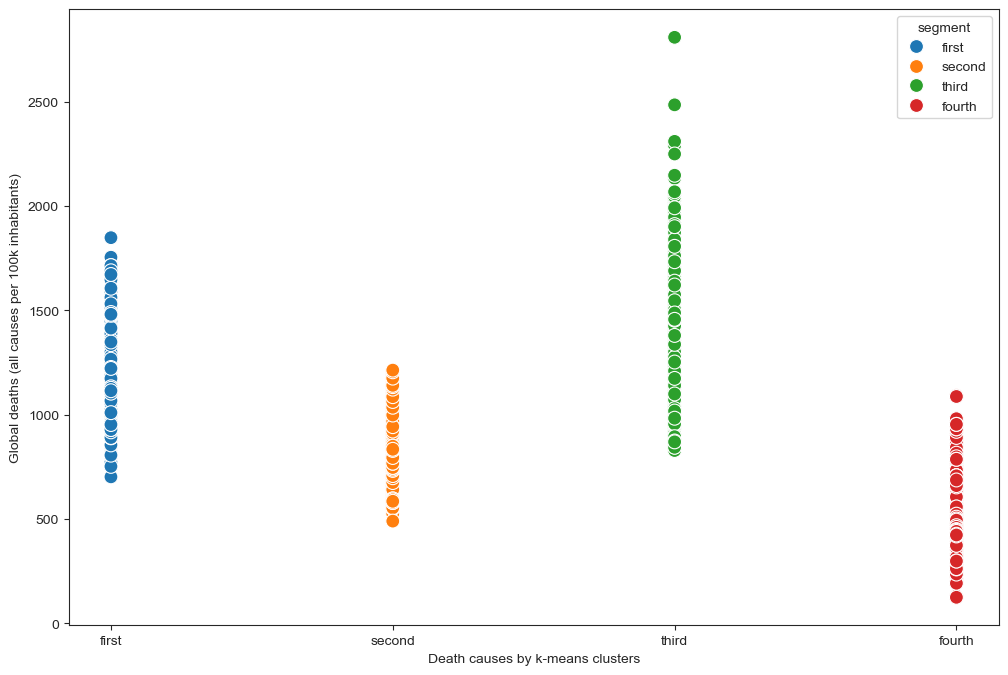

In [136]:
#plotting the cluster of distinct death causes to the global death counts
plt.figure(figsize=(12,8))
sns.color_palette("husl", 8)
hue_order = ['first','second','third','fourth'] #for keeping a coherent color code among the clusters
ax = sns.scatterplot(data=df_sub_pca_kmeans, y='A-R_V-Y: All causes of death (A00-Y89) excluding S00-T98', x='segment', hue='segment', hue_order=hue_order,s=100)
ax.grid(False)
plt.xlabel('Death causes by k-means clusters')
plt.ylabel('Global deaths (all causes per 100k inhabitants)') 
plt.show()

All 4 clusters of distinct death causes have no equal impact on the total death counts , with a higher mortality on the third and first clusters, while  the fourth tend to have lower deaths.

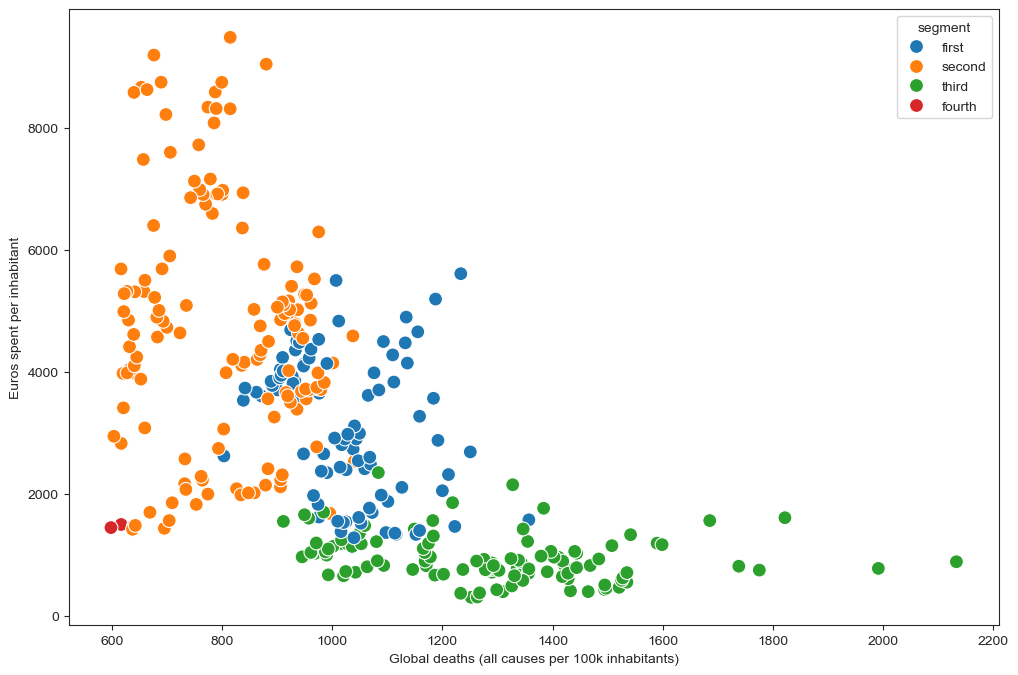

In [138]:
# Plotting the clusters for the euros per inhabitant and the global deaths
plt.figure(figsize=(12,8))
sns.color_palette("husl", 8)
ax = sns.scatterplot(data=df_sub_pca_kmeans, x='A-R_V-Y: All causes of death (A00-Y89) excluding S00-T98', y='euros_per_inhabitant', hue='segment', hue_order=hue_order, s=100)
ax.grid(False)
plt.xlabel('Global deaths (all causes per 100k inhabitants)')
plt.ylabel('Euros spent per inhabitant') 
plt.show()

The four clusters aren't that separate from each other, with the second and third on the exrteme values on both variables. Death caused by the secdond cluster have less counts and more spent money, while the third cluster has high death counts and very low expenditures.

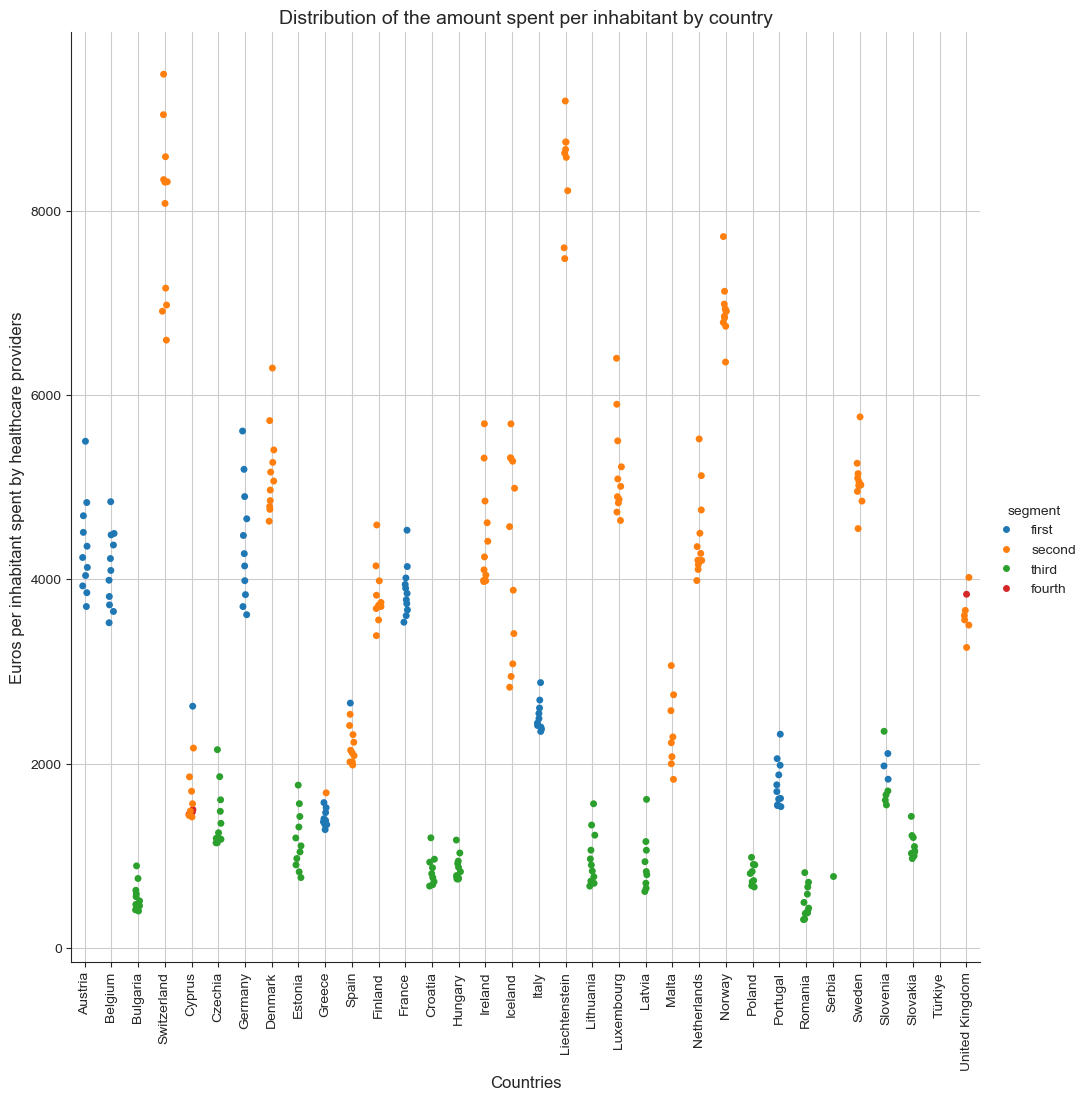

In [140]:
#subsetting to keep only ciountries entries (no regions)
df_country = df_sub_pca_kmeans[df_sub_pca_kmeans['geo_code'].str.len() == 2]

#ploting the countries with the clusters and healthcare providers' expenditures - geographical impact ?
sns.set_style("ticks")
sns.color_palette('colorblind')
g = sns.catplot(x='country_region', y='euros_per_inhabitant', hue='segment',hue_order=hue_order, data=df_country, legend_out =True, ax =ax, height = 10)
plt.title('Distribution of the amount spent per inhabitant by country', fontsize=14)
plt.xlabel('Countries', fontsize =12)
plt.xticks(rotation=90)
plt.ylabel('Euros per inhabitant spent by healthcare providers', fontsize =12)
plt.grid()
plt.show()

Countries with low expenditures tend to have similar death causes from the third and fourth clusters, while the other countries with more expenditures have blended clusters of death causes, with first and second clusters.

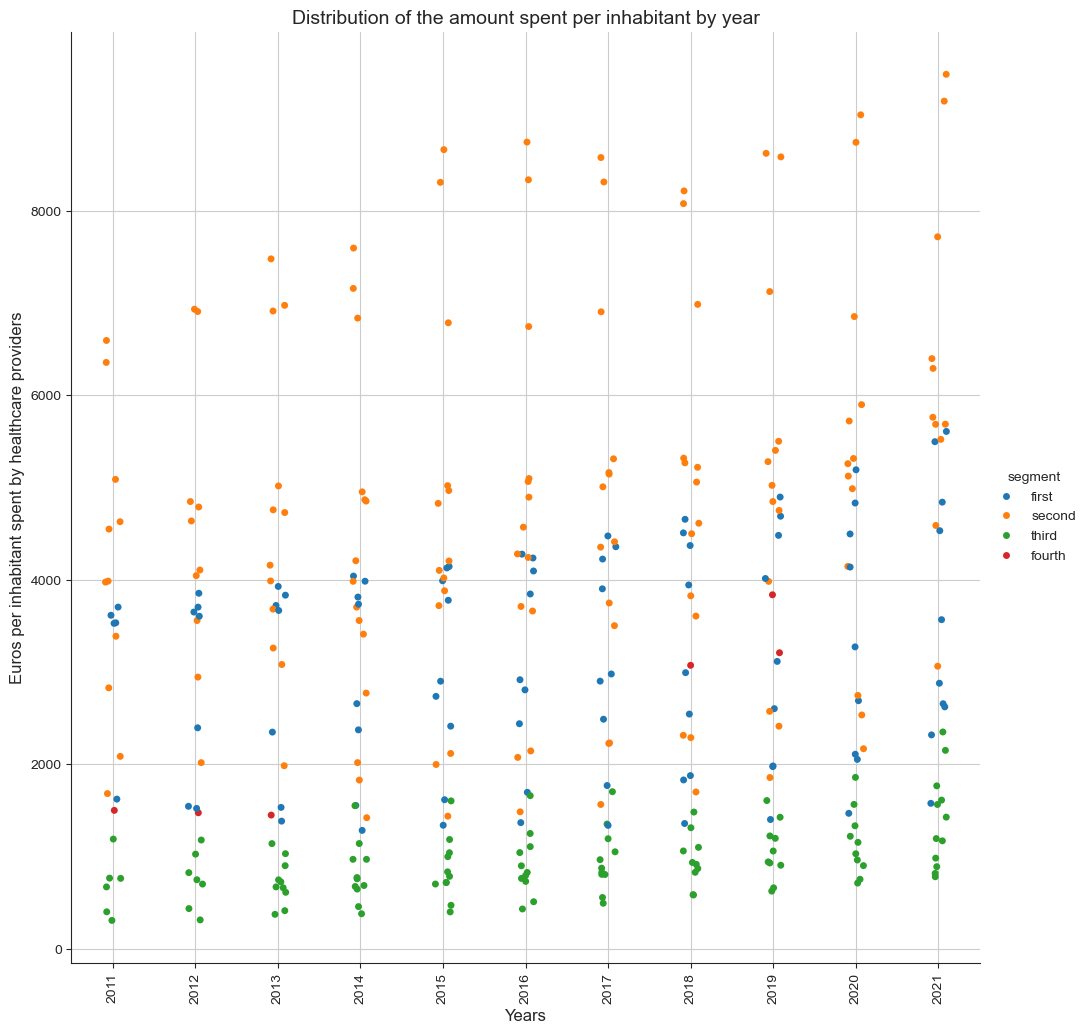

In [142]:
##ploting the years with the clusters and healthcare providers' expenditures - time impact ?
sns.set_style("ticks")
sns.color_palette('colorblind')
g = sns.catplot(x='year', y='euros_per_inhabitant', hue='segment', hue_order=hue_order, data=df_sub_pca_kmeans, legend_out =True, ax =ax, height = 10)
plt.title('Distribution of the amount spent per inhabitant by year', fontsize=14)
plt.xlabel('Years', fontsize =12)
plt.xticks(rotation=90)
plt.ylabel('Euros per inhabitant spent by healthcare providers', fontsize =12)
plt.grid()
plt.show()

We notice the positive evolution of expenditures, but the clusters of death causes are very similar across time.

In [144]:
df_sub_pca_kmeans.groupby('segment').agg({'euros_per_inhabitant':['mean', 'median'], 
                         'A-R_V-Y: All causes of death (A00-Y89) excluding S00-T98':['mean', 'median'], 
                         'physicians_per_100K_inhabitants':['mean', 'median'],
                          'beds_per_100K_inhabitants':['mean', 'median']})

euros_per_inhabitant            \
                        mean    median   
segment                                  
first            3153.662967  3273.910   
fourth           2424.768333  2287.495   
second           4792.937801  4753.390   
third             955.988257   899.980   

        A-R_V-Y: All causes of death (A00-Y89) excluding S00-T98           \
                                                            mean   median   
segment                                                                     
first                                          1092.025788        1069.63   
fourth                                          537.935597         531.68   
second                                          858.371925         863.18   
third                                          1258.194447        1232.89   

        physicians_per_100K_inhabitants          beds_per_100K_inhabitants  \
                                   mean   median                      mean   
segment                                                                      
first                        385.890333  369.985                474.818535   
fourth                       194.388356  175.710                299.100792   
second                       375.806922  375.420                395.220048   
third                        324.463936  316.740                654.666797   

                  
          median  
segment           
first    425.460  
fourth   283.885  
second   348.355  
third    651.795

In [ ]:
#Saving the final file with the clusters included for future reference in Tableau
df_sub_pca_kmeans.to_excel(os.path.join(path_data,'Prepared data', 'cod_clust.xlsx'), index =False)

## 5. Conclusions
<div id='5'></div>

*Side note : the same study as been done with 5 clusters as well, keeping only 4 was visually more impactful*

The clusters on all the distinct death causes, once compared to the other variables of the initial data set show that death causes have an impact on the global deaths in Europe:

- This study had the advantage of grouping the too many death causes, on a statistical and not on a medical level, and see the impact or relation as a complement of the precedent analysis.
- As such, without knowing which causes are inside each cluster, we can point out that some death causes are more likely to happen in countries where healthcare providers spend less money per inhabitant, while its contrary isn't as clear.
- With a bit of european geography (a map could be useful), the said poorer countries are mostly in the Eastern corners of Europe, meaning there could also be a geographical explanation and not only a spending one for these clusters'differences.
- Year by year, the clusters are quite consitant with almost no evolution, meaning the causes of deaths have not changed much these last 11 years in Europe.
- The last statistics shows that the second cluster of death causes share the best relation between deaths and healthcare resources: the best scores on euros spent, almost on death counts (the fifth being very small has less death counts).
- This second cluster is mostly situated in moderate and high spending countries.
- Clusters separations are very clear on contries, meaning that the location where people live is very relevant when comparing death causes in Europe.